NAMES: David Rickards (me) & Bibiana Garcia worked on this

## Final Assignment Overview: Working with Patient Records and Encounter Notes FIRST HALF


In [ ]:
# Single note example to use for testing
encounter_note_medical = """
AMBULATORY ENCOUNTER NOTE
Date of Service: March 2, 2020 15:45-16:30

DEMOGRAPHICS:
Name: Jeffrey Greenfelder
DOB: 1/16/2005
Gender: Male
Address: 428 Wiza Glen Unit 91, Springfield, Massachusetts 01104
Insurance: Guardian
MRN: 055ae6fc-7e18-4a39-8058-64082ca6d515

PERTINENT MEDICAL HISTORY:
- Obesity
Current Medications:
- Hydrochlorothiazide 12.5 MG daily
- Fluticasone/Salmeterol 250/50 mcg inhaler BID
- Hydrochloride Meperidine 50 MG Oral Tablet
Recent Visit: Well child visit (2/23/2020)
Immunizations: Influenza vaccine (2/23/2020)

Recent Baseline (2/23/2020):
Height: 155.0 cm
Weight: 81.2 kg
BMI: 33.8 kg/m² (99.1th percentile)
BP: 123/80 mmHg
HR: 92/min
RR: 13/min

SUBJECTIVE:
Adolescent patient presents with multiple symptoms including:
- Cough
- Sore throat
- Severe fatigue
- Muscle pain
- Joint pain
- Fever
Never smoker. Symptoms began recently.

OBJECTIVE:
Vitals:
Temperature: 39.3°C (102.7°F)
Heart Rate: 131.1/min
Blood Pressure: 120/73 mmHg
Respiratory Rate: 27.6/min
O2 Saturation: 75.8% on room air
Weight: 81.2 kg

Laboratory/Testing:
Comprehensive Respiratory Panel:
- Influenza A RNA: Negative
- Influenza B RNA: Negative
- RSV RNA: Negative
- Parainfluenza virus 1,2,3 RNA: Negative
- Rhinovirus RNA: Negative
- Human metapneumovirus RNA: Negative
- Adenovirus DNA: Negative
- SARS-CoV-2 RNA: Positive

ASSESSMENT:
1. Suspected COVID-19 with severe symptoms
2. Severe hypoxemia requiring immediate intervention
3. Tachycardia (HR 131)
4. High-grade fever
5. Risk factors:
   - Obesity (BMI 33.8)
   - Adolescent age

PLAN:
1. Face mask provided for immediate oxygen support
2. Infectious disease care plan initiated
3. Close monitoring required due to:
   - Severe hypoxemia
   - Tachycardia
   - Age and obesity risk factors
4. Parent/patient education on:
   - Home isolation protocols
   - Warning signs requiring emergency care
   - Return precautions
5. Follow-up plan:
   - Daily monitoring during acute phase
   - Virtual check-ins as needed

Encounter Duration: 45 minutes
Encounter Type: Ambulatory
Provider: ID# e2c226c2-3e1e-3d0b-b997-ce9544c10528
Facility: 5103c940-0c08-392f-95cd-446e0cea042a
"""

In [1]:
# Install Libraries
!pip install --upgrade openai
!pip install --upgrade transformers
!pip install langchain
!pip install langchain_openai
!pip install --upgrade langchain_openai langchain_core
!pip install --upgrade openai langchain_openai
!pip install faiss-cpu
!pip install pandas pyarrow pyspark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [133]:
# Import Libraries
import time
import os
import csv
import json
import gzip
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from openai import OpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field    # TAKE A LOOK AT Pydantic AI
from typing import List, Optional
from pathlib import Path
from sentence_transformers import SentenceTransformer

from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, count, when, lit, date_format, year, month, when, explode, rank, lower, avg, mean, stddev

# Becuse I am useing google colab and all my files are in my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# if I use spark it will be for the encounter note but I don;t need to encode those
spark = SparkSession.builder.appName("All Encounter Notes").getOrCreate()

# Read the csv into a df
medications_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/medications_assignment_1.csv')
immunizations_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/immunizations_assignment_1.csv')
encounters_types_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/encounters_types_assignment_1.csv')
observations_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/observations_assignment_1.csv')

# This is larger so use spark
encounters_df = df = spark.read.csv('/content/drive/My Drive/Colab Notebooks/Data/encounters_assignment_1.csv', header=True, inferSchema=True)

In [ ]:
# Classes

# the encounter type for the exampl is not listed in the csv so there is not code??
class EncounterType(BaseModel):
    code: Optional[str] = Field(default=None)
    description: Optional[str] = Field(default=None, description=" the type of encounter. Should be after PLAN section near the bottom of the encounter note")

class Encounter(BaseModel):
    # id: str  # is this supposed to be MRN or the provider id?
    date: Optional[str] = Field(default=None, description="The date of the encounter. Should be located in the AMBULATORY ENCOUNTER NOTE header")
    time: Optional[str] = Field(default=None, description="The time of the encounter. Should be located in the AMBULATORY ENCOUNTER NOTE header")
    type: Optional[EncounterType]  # Assuming EncounterType is defined elsewhere
    provider_id: Optional[str] = Field(default=None, description="The provider's ID number. Should be after the PLAN section near the bottom of the encounter note")
    facility_id: Optional[str] = Field(default=None, description="The facility's identifier. Should be after the PLAN section near the bottom of the encounter note")

# is this necessary bc it is stated in the note?
class Address(BaseModel):
    city: Optional[str] = Field(default=None, description=" the city where the patient lives. Should be under DEMOGRAPHICS header")
    state: Optional[str] = Field(default=None, description=" the state where the patient lives. Should be under DEMOGRAPHICS header")

class Demographics(BaseModel):
    name: Optional[str] = Field(default=None, description=" the name of the patient located under DEMOGRAPHICS header. If the name is not recorded print out 'Invalid encounter note' and stop reading everything")
    date_of_birth: Optional[str] = Field(default=None, description=" the DOB of the patient located under DEMOGRAPHICS header")
    age: Optional[int] = Field(default=None, description=" the age of the patient on the day of the encounter. If not specified calculate their age by using their DOB and the date of service")
    gender: Optional[str] = Field(default=None, description=" the gender of the patient located under DEMOGRAPHICS header")
    address: Optional[Address] = Field(default=None, description=" the address of the patient located under DEMOGRAPHICS header")
    insurance: Optional[str] = Field(default=None, description=" the insurance provider of the patient located under DEMOGRAPHICS header")

# like symptoms under the sunjective or under the assesment? ? ? ? ? ?
class Condition(BaseModel):
    code: Optional[str] = Field(default=None) # observations
    description: Optional[str] = Field(default=None, description=" each symptom the patiant has. Should be under SUBJECTIVE header")

# medication is not always there so maybe do it as a sperate prompt?
class Medication(BaseModel):
    code: Optional[str]  #  medications
    description: Optional[str] = Field(default=None, description=" each medication the patiant is currently taking. Should be located under Current Medications under PERTINENT MEDICAL HISTORY header. NOTE: if an encounter note does not have Current Medications under the PERTINENT MEDICAL HISTORY header do nothing for this")

class Immunization(BaseModel) :
    code: Optional[str]  #imunizations
    description: Optional[str] = Field(default=None, description=" each immunization the patiant has had. Should be located under Immunizations under PERTINENT MEDICAL HISTORY header. NOTE: if an encounter note does not have Immunizations under the PERTINENT MEDICAL HISTORY header do nothing for this")
    date: Optional[str] = Field(default=None, description=" the date of that immunization")

class VitalMeasurement(BaseModel) :
    code: Optional[str] # observations
    value: Optional[float] = Field(default=None, description=" the value of this specified vital")
    unit: Optional[str] = Field(default=None, description=" the unit attached to the value of this scpecified vital")

class BloodPressure(BaseModel):
    systolic: Optional[VitalMeasurement] = Field(default=None, description=" the systolic value of the patiants blood pressure")
    diastolic: Optional[VitalMeasurement] = Field(default=None, description=" the diastolic value of the patiants blood pressure")

class CurrentVitals(BaseModel): # Everything under OBJECTIVE
    temperature: Optional[VitalMeasurement] = Field(default=None, description=" the current temepture of the patiant. Should be located under OBJECTIVE header")
    heart_rate: Optional[VitalMeasurement] = Field(default=None, description=" the current heart rate of the patiant. Should be located under OBJECTIVE header")
    blood_pressure: Optional[BloodPressure] = Field(default=None, description=" the current blood pressure of the patiant. Should be located under OBJECTIVE header")
    respiratory_rate: Optional[VitalMeasurement] = Field(default=None, description=" the current respiratory rate of the patiant. Should be located under OBJECTIVE header")
    oxygen_saturation: Optional[VitalMeasurement] = Field(default=None, description=" the current oxygen saturation of the patiant. Should be located under OBJECTIVE header")
    weight: Optional[VitalMeasurement] = Field(default=None, description=" the current weight of the patiant. Should be located under OBJECTIVE header")

class BaselineVitals(BaseModel):  # OPTINON example in (note: 055ae6fc-7e18-4a39-8058-64082ca6d515.txt)
    date: Optional[str] = Field(default=None, description=" the date of baseline (previous vitals). NOT UNDER OBJECTIVE! Should be located under Last Known Baseline under PERTINENT MEDICAL HISTORY header")
    height: Optional[VitalMeasurement] = Field(default=None, description=" the baseline (previously recorded) hight of patiant. NOT UNDER OBJECTIVE! Should be located under Last Known Baseline under PERTINENT MEDICAL HISTORY header")
    weight: Optional[VitalMeasurement] = Field(default=None, description=" the baseline (previous recorded) hight of patiant. NOT UNDER OBJECTIVE! Should be located under Last Known Baseline under PERTINENT MEDICAL HISTORY header")
    bmi: Optional[VitalMeasurement] = Field(default=None, description=" the baseline (previous recorded) BMI of patiant. NOT UNDER OBJECTIVE! Should be located under Last Known Baseline under PERTINENT MEDICAL HISTORY header")
    bmi_percentile: Optional[VitalMeasurement] = Field(default=None, description=" the baseline (previous recorded) BMI percentile attached to the baseline bmi of patiant. NOT UNDER OBSERVATION! Should be located under Last Known Baseline under PERTINENT MEDICAL HISTORY header")
    blood_pressure: Optional[BloodPressure] = Field(default=None, description=" the baseline (previous recorded) blood pressure of patiant. NOT UNDER OBJECTIVE! Should be located under Last Known Baseline under PERTINENT MEDICAL HISTORY header")

class Vitals(BaseModel):
    current: Optional[CurrentVitals] = Field(default=None, description=" the current vitals of the patiant. Should be located under OBJECTIVE header")
    baseline: Optional[BaselineVitals] = Field(default=None, description=" the baseline vitals of the patiant. NOT UNDER OBJECTIVE! Should be located under Last Known Baseline under PERTINENT MEDICAL HISTORY header")

class RespiratoryTest(BaseModel):
    code: Optional[str] # observations
    result: Optional[str] = Field(default=None, description=" the result of the test. Should be located under Laboratory/Testing under OBJECTIVE header")

class RespiratoryPanel(BaseModel):
    influenza_a: Optional[RespiratoryTest] = Field(default=None, description=" the result of the Influenza A RNA test for the patiant. Should be located under Laboratory/Testing under OBJECTIVE header")
    influenza_b: Optional[RespiratoryTest] = Field(default=None, description=" the result of the Influenza B RNA test for the patiant. Should be located under Laboratory/Testing under OBJECTIVE header")
    rsv: Optional[RespiratoryTest] = Field(default=None, description=" the result of the RSV RNA test for the patiant. Should be located under Laboratory/Testing under OBJECTIVE header")
    parainfluenza_1: Optional[RespiratoryTest] = Field(default=None, description=" the result of the Parainfluenza virus 1 RNA test for the patiant. Should be located under Laboratory/Testing under OBJECTIVE header")
    parainfluenza_2: Optional[RespiratoryTest] = Field(default=None, description=" the result of the Parainfluenza virus 2 RNA test for the patiant. Should be located under Laboratory/Testing under OBJECTIVE header")
    parainfluenza_3: Optional[RespiratoryTest] = Field(default=None, description=" the result of the Parainfluenza virus 3 RNA test for the patiant. Should be located under Laboratory/Testing under OBJECTIVE header")
    rhinovirus: Optional[RespiratoryTest] = Field(default=None, description=" the result of the Rhinovirus RNA test for the patiant. Should be located under Laboratory/Testing under OBJECTIVE header")
    metapneumovirus: Optional[RespiratoryTest] =  Field(default=None, description=" the result of the Human metapneumovirus RNA test for the patiant. Should be located under Laboratory/Testing under OBJECTIVE header")
    adenovirus: Optional[RespiratoryTest] = Field(default=None, description=" the result of the Adenovirus DNA test for the patiant. Should be located under Laboratory/Testing under OBJECTIVE header")

class Covid19Test(BaseModel):
    code: Optional[str]  # observation
    description: Optional[str] = Field(default=None, description=" a detailed description of the COVID-19 test performed, such as 'SARS-CoV-2 RNA test'")
    result: Optional[str] = Field(default=None, description=" the result of the COVID-19 test, such as 'Not detected', 'Detected', or 'Inconclusive'. Found under Laboratory/Testing header")

class Laboratory(BaseModel):
    covid19: Optional[Covid19Test] = Field(default=None, description="The COVID-19 test. Typically found under the Laboratory/Testing section, but may appear elsewhere in encounter notes depending on the context.")
    respiratory_panel: Optional[RespiratoryPanel] = Field(default=None, description="The results of the respiratory pathogen panel. Typically located under Laboratory/Testing, but the exact location may vary in different encounter notes.")

class Procedure(BaseModel):
    code: Optional[str]   = Field(default=None)# not sure what this is
    description: Optional[str] =  Field(default=None, description="A description of the procedure performed. Typically found in the Procedures or Plan section.")
    date: Optional[str] = Field(default=None, description="The date when the procedure was performed. Typically found in the Procedures or Plan section.")
    reasonCode: Optional[str] = Field(default=None, description="The code indicating the reason for the procedure. May be found in the Procedures, Plan, or Assessment section.")
    reasonDescription: Optional[str] = Field(default=None, description="A description of the reason for the procedure. May be found in the Procedures, Plan, or Assessment section.")

class CarePlan(BaseModel):
    id: Optional[str] = Field(default=None, description="An identifier for the care plan. This may be located in sections detailing care plans or treatment plans, often under a PLAN or ASSESSMENT header.")
    code: Optional[str] = Field(default=None)  # NOT SURE WHAT THIS IS
    description: Optional[str] = Field(default=None, description="A textual description of the care plan. May be located in PLAN or similar headers, summarizing the goals and steps of the care plan.")
    start: Optional[str] = Field(default=None, description="The start date/time of the care plan. This information may be included under PLAN, ASSESSMENT, or specific care plan sections.")
    stop: Optional[str] = Field(default=None, description="The stop date/time of the care plan, if applicable. Could be found in PLAN, ASSESSMENT, or discharge instructions sections.")
    reasonCode: Optional[str] = Field(default=None, description="A code explaining the reason for the care plan. This might appear near the care plan details or in diagnostic sections of the note.")
    reasonDescription: Optional[str] = Field(default=None, description="A description of the reason for the care plan. Look for this information in PLAN, ASSESSMENT, or reason-for-treatment sections.")

class PatientRecord(BaseModel): # This object holds information about the patient.
  encounter: Optional[Encounter] = Field(default=None)
  conditions: Optional[List[Condition]] = Field(default=None)
  demographics: Optional[Demographics] = Field(default=None)
  medications: Optional[List[Medication]] = Field(default=None)
  immunizations: Optional[List[Immunization]] = Field(default=None)
  vitals: Optional[Vitals] = Field(default=None)
  laboratory: Optional[Laboratory] = Field(default=None)
  procedures: Optional[List[Procedure]] = Field(default=None)


In [ ]:
# Load the model to encode descriptions
model = SentenceTransformer('all-MiniLM-L6-v2')

#take vice and use fiass to pull the context to only grab the best.
def create_faiss_index(column_name, df):
  # Encode the descriptions into embeddings from the medication dataframe
  description_embeddings = model.encode(df[column_name].tolist()).astype('float32')

  # Initialize FAISS index (L2 distance for similarity)
  index = faiss.IndexFlatL2(description_embeddings.shape[1])

  # Add the description embeddings to the FAISS index
  index.add(description_embeddings)

  return index

In [ ]:
# Create index from each file (I keep them seperate in case of overlapping things that would mix the codes up)
medications_index = create_faiss_index('DESCRIPTION', medications_df)
immunizations_index = create_faiss_index('DESCRIPTION', immunizations_df)
encounters_types_index = create_faiss_index('DESCRIPTION', encounters_types_df)
observations_index = create_faiss_index('Left ventricular Ejection fraction', observations_df)

In [ ]:
# These are fix varible names that will be used to pull appreopriate matches
baseline_names = ['height', 'weight', 'bmi', 'bmi_percentile', 'blood_pressure.systolic', 'blood_pressure.diastolic']
current_names = ['temperature', 'heart_rate', 'blood_pressure', 'respiratory_rate', 'oxygen_saturation', 'weight']
respiratory_panel_names = ['influenza_a', 'influenza_b', 'rsv', 'parainfluenza_1', 'parainfluenza_2', 'parainfluenza_3', 'rhinovirus', 'metapneumovirus', 'adenovirus']

In [ ]:
# I see that CarePlan and Procedure have codes too but IDK where they are stored bc they don;t look to be under observations
# I am also kinda confused on that in general so I am just going to focus on the other parts for now

In [ ]:
# Finds the closest item to gpts results then returns subset of the df for next gpt prompt
def closets(query_list, index, df):

  subset = []
  seen_indices = set()

  for item in query_list:
    # Encode the query into a vector
    query_vector = model.encode([item]).astype('float32')

    # Search the FAISS index (top 2 closest matches)
    distances, indices = index.search(query_vector, 2)

    # Append the closest rows
    for idx in indices[0]:
      if idx != -1 and idx not in seen_indices: # Check for valid  indices
        subset.append(df.iloc[idx].to_dict())  # Convert row to dictionary
        seen_indices.add(idx)  # Mark this index as added

  # Convert the list of rows back into a DataFrame
  return pd.DataFrame(subset)

In [ ]:
#  Creating small classes just for the lists for classes
class MedicationList(BaseModel):
    medications: List[Medication]

class ImmunizationList(BaseModel):
    immunizations: List[Immunization]

class ConditionList(BaseModel):
    conditions: List[Condition]

In [ ]:
# Function to process FAISS and GPT prompting in a try catch for SINGLE items
def process_section_single(name, collected_data, description, index, df, structure):
  try:
    if collected_data != None:
      subset_df = closets(description, index, df) # Creates matching subset and then WHICH IS CORRECT
      #print(f"Processing {name} for subset: {subset_df}")

      # For some reason gpt is not replacing the 'None' value witht he correct one event though it did originally? I spent 5 hours looking at this and got no where so I got to upset
      # it give the correct subset, data, and dataframe so idk whats up. and It only updates immunizations????
      collected_data = get_gpt_response(structure, subset_df, collected_data) # Returns filled with codes

  except Exception as e:
    print(f"Error re-processing {name} for codes")

  return collected_data


In [ ]:
# Keys

# Api key and GPT Model
llm = ChatOpenAI(
    api_key=davidkey,
    model="gpt-4o"
    )
def intial_gpt_get(encounter_note):
  # Desired output example structure
  structured_llm = llm.with_structured_output(PatientRecord)

  # GPT Prompt
  prompt_str = """
  Follow the format and extract the appropriate information (leave code values blank or set them to null if not available) from the below encounter note. Ensure all required fields are present in the output.

  Encounter Note:
  {encounter_note}

  """
  # chaining
  prompt = PromptTemplate.from_template(prompt_str)
  structured_chain = prompt | structured_llm

  # Feeding single to GPT
  return structured_chain.invoke({"encounter_note": encounter_note})

In [ ]:
# Prompt for adding codes to the dataset from the
prompt_str_2 = '''
ONLY REPLACE THE 'code' varaiable
Using the given subset below, match the descriptions and replace the 'None' for appreopreate codes in 'Collected Data'.

Instructions:
1. Focus on matching the key components of descriptions, such as:
   - Important terms, names, values, units, or numerical details.
2. Be tolerant of formatting differences:
   - Variations in units (e.g., 'mcg' vs 'MG') or formatting (e.g., '155 cm' vs '155.0 cm') should be considered equivalent.
   - Ignore minor variations like prefixes, suffixes, or additional descriptors (e.g., 'Metered Dose Inhaler' or 'Type A measurement').
3. Correct any spelling errors, typos, flipped words or case differences in Collection Data descriptions as necessary.
4. Prioritize matches where descriptions closely align semantically, even if exact wording or formatting differs.
5. **Only insert numerical or valid identifier values for the 'code' field.**
   - 'code' fields **must not contain words, descriptions, or letters**.
   - If no valid match exists in the 'SUBSET', leave the code field unchanged.

6. Ensure the updated version of 'Collected Data' strictly adheres to its original structure.
   - Do not add or remove variables other than code.
   - Do not insert descriptive text into fields that require specific formats like numbers or codes.

If a variable in 'Collected Data' does not have a value or no appropriate match exists, leave the code value unchanged.

Your response should include the updated version of 'Collected Data', formatted identically to its original structure.

SUBSET:
{subset}

Collected Data:
{data}
'''


# Funstion that sends the data sn subset of codes to gpt to returna a more complete data
def get_gpt_response(data_structures, subset, data):
  structured_llm = llm.with_structured_output(data_structures)

  prompt = PromptTemplate.from_template(prompt_str_2)
  structured_chain = prompt | structured_llm

  return structured_chain.invoke({"subset": subset, "data": data})

In [ ]:
def process_encounter_note(encounter_note):

  # Inital results of gpt
  response = intial_gpt_get(encounter_note)  # I have not had a problem with this file so I don't have try catch I jinxed it

  # Process all Single sections
  process_section_single("baseline vitals", response.vitals.baseline, baseline_names, observations_index, observations_df, BaselineVitals)
  process_section_single("current vitals", response.vitals.current, current_names, observations_index, observations_df, CurrentVitals)
  process_section_single("respiratory panel", response.laboratory.respiratory_panel, respiratory_panel_names, observations_index, observations_df, RespiratoryPanel)
  process_section_single("encounter type", response.encounter.type, response.encounter.type.description, encounters_types_index, encounters_types_df, EncounterType)
  process_section_single("covid19 test", response.laboratory.covid19, response.laboratory.covid19.description, observations_index, observations_df, Covid19Test)

  # Dynamic Subsets of Data
  # Process all List Items   I was gonna make another function in a try catch but got lazy :/
  try:
    if response.medications != None:
      medications_subset_df = closets([med.description for med in response.medications], medications_index, medications_df)
      response.medications = get_gpt_response(MedicationList, medications_subset_df, (response.medications)).medications
  except Exception as e:
    print(f"Error re-processing medications for codes")

  try:
    if response.immunizations != None:
      immunizations_subset_df = closets([immun.description for immun in response.immunizations], immunizations_index, immunizations_df)
      response.immunizations = get_gpt_response(ImmunizationList, immunizations_subset_df, (response.immunizations)).immunizations
  except Exception as e:
    print(f"Error re-processing immunizations for codes")

  try:
    if response.conditions != None:
      conditions_subset_df = closets([cond.description for cond in response.conditions], observations_index, observations_df)
      response.conditions = get_gpt_response(ConditionList, conditions_subset_df, (response.conditions)).conditions
  except Exception as e:
    print(f"Error re-processing conditions for codes")

  return response # return the whole (completed to the best that it can) object


In [ ]:
# Reads each of the encounter notes in the folder and runs calls the gpt functions
patient_records = []
drive_path = Path('/content/drive/My Drive/Colab Notebooks/Encounter Notes')

for file in drive_path.iterdir():

  try:    # catch error
    with open(file, "r", encoding="utf-8") as f: # Read the txt files
      encounter_note = f.read()
      record = process_encounter_note(encounter_note)
      patient_records.append(record)      # I just store them all in a list for easy access
      print(f"Successfully processed {file}")

  except Exception as e:
    print(f"Error processing {file}")

Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_11.txt
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_10.txt
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_9.txt_
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_7.txt
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_8.txt
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_5.txt
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_4.txt
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_3.txt
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_2.txt
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_1.txt
Successfully processed /content/drive/My Drive/Colab Notebooks/Encounter Notes/en_6.txt


# Part 2 : Basic Analytics and Visualizations:
Using Apache Spark, perform comprehensive data analysis on the encounter data and create visualizations that reveal meaningful patterns. Your analysis must include:
- COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])
- Cumulative case count of Covid between the earliest case observed in the dataset and last case observed
- Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.
- Rank medications by frequency of prescription
- Analyze medication patterns across different demographic groups (e.g., top 3 per age group)
- Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset.
- An independent group analysis: You need to develop and execute THREE original analyses that provide meaningful insights about COVID-19 patterns in this dataset. For each analysis:
  - Clearly state your analytical question/hypothesis
  - Justify why this analysis is valuable
  - Show your Spark code and methodology
  - Present results with appropriate visualizations

In [126]:
# File Paths
data_path = '/content/drive/MyDrive/ICS438/Assignment3/parsed_notes.jsonl.gz'
schema_path = '/content/drive/MyDrive/ICS438/Assignment3/schema.py'

# HELPER FUNCTIONS
# Function to track and print time taken for processing
def track_time(start_time):
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTime taken to process the file: {elapsed_time:.4f} seconds")


def get_spark_dataframe():
  # Set up Spark DataFrames
  spark = SparkSession.builder.appName("spark_analysis").getOrCreate()
  # Load Patient Records into DataFrame (Apache Spark can automatically read from .jsonl.gz)
  df = spark.read.json(data_path)
  # Add the 'age_group' column to the DataFrame
  df_age_groups = df.withColumn(
      "age_group",
      when(col("demographics.age") <= 5, "[0-5]")
      .when((col("demographics.age") >= 6) & (col("demographics.age") <= 10), "[6-10]")
      .when((col("demographics.age") >= 11) & (col("demographics.age") <= 17), "[11-17]")
      .when((col("demographics.age") >= 18) & (col("demographics.age") <= 30), "[18-30]")
      .when((col("demographics.age") >= 31) & (col("demographics.age") <= 50), "[31-50]")
      .when((col("demographics.age") >= 51) & (col("demographics.age") <= 70), "[51-70]")
      .otherwise("[71+]")
  )
  # Filter for positive COVID-19 results
  df_covid_positive = df_age_groups.filter(
      col("laboratory.covid19.result")  == "Detected (qualifier value)"
      )
  return df_covid_positive, df_age_groups

# SPARKDATAFRAME GLOBAL VARIABLES
spark_dataframe, age_groups_dataframe = get_spark_dataframe()

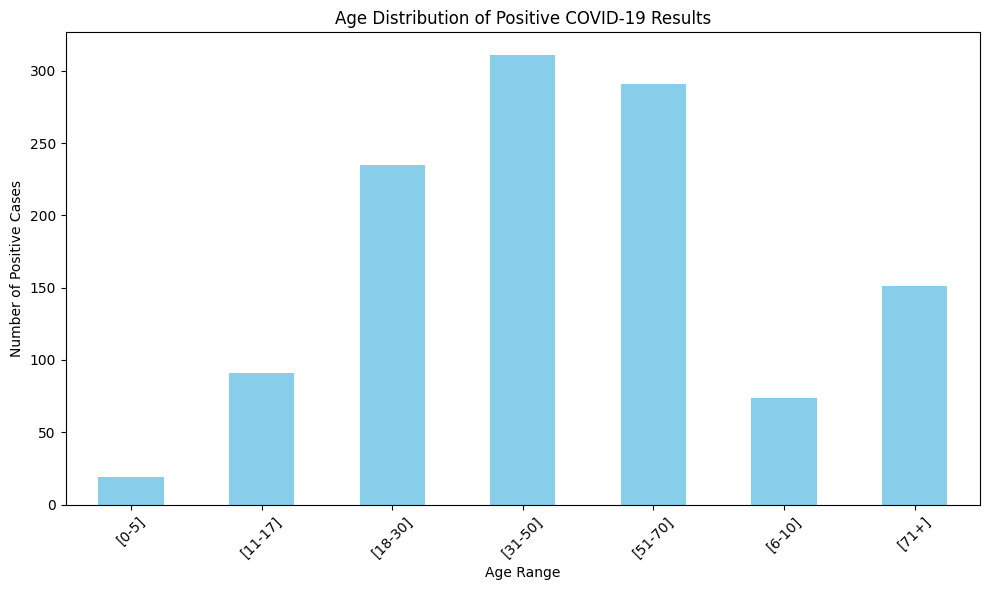

DataFrame[age_group: string, count: bigint]

In [102]:
# Visualization 1: Cumulative case count of Covid between the earliest case observed in the dataset and last case observed
def covid_pos_by_age(dataframe, show=True):
  covid_by_group= dataframe.groupBy("age_group").count().orderBy("age_group")
  if show:
    # Convert to Pandas for visualization
    age_distribution_pd = covid_by_group.toPandas()
    # Set 'age_group' as the index for better visualization
    age_distribution_pd.set_index('age_group', inplace=True)
    # Create a bar plot
    age_distribution_pd.plot(
        kind='bar',
        figsize=(10, 6),
        legend=False,
        color='skyblue',
        xlabel='Age Range',
        ylabel='Number of Positive Cases',
        title='Age Distribution of Positive COVID-19 Results'
    )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
  return covid_by_group

covid_pos_by_age(spark_dataframe)

In [104]:
# Visualization 2: Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.
def ICU_symptoms_distribution(dataframe, show=True):

  # Separate ICU and non-ICU patients
  covid_patients = dataframe.withColumn(
      "icu_status",
      when(col("encounter.facility_id") == "ICU", "ICU").otherwise("Non-ICU")
  )

  # Explode the conditions array to get one row per symptom
  covid_symptoms = covid_patients.select(
      "age_group", "icu_status", explode("conditions.description").alias("symptom")
  )

  # Group by age range and ICU status, count symptoms
  symptom_distribution = covid_symptoms.groupBy("age_group", "icu_status").count()

  # Pivot the data for visualization
  symptom_distribution_pivot = symptom_distribution.groupBy("age_group").pivot("icu_status").sum("count").fillna(0)

  if show:
    # Convert to Pandas DataFrame
    symptom_distribution_pd = symptom_distribution_pivot.toPandas()

    # Ensure data is sorted by age range
    symptom_distribution_pd = symptom_distribution_pd.sort_values(by="age_group")

    # Plot grouped bar chart
    age_groups = symptom_distribution_pd["age_group"]
    icu_counts = symptom_distribution_pd["ICU"]
    non_icu_counts = symptom_distribution_pd["Non-ICU"]

    x = np.arange(len(age_groups))  # The label locations
    width = 0.35  # The width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, non_icu_counts, width, label="Non-ICU", color="skyblue")
    bars2 = ax.bar(x + width/2, icu_counts, width, label="ICU", color="orange")

    # Add labels, title, and legend
    ax.set_xlabel("Age Range")
    ax.set_ylabel("Number of Symptoms")
    ax.set_title("Age Distribution of Symptoms: COVID-19 Patients (ICU vs Non-ICU)")
    ax.set_xticks(x)
    ax.set_xticklabels(age_groups, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

ICU_symptoms_distribution(spark_dataframe)

KeyError: 'ICU'

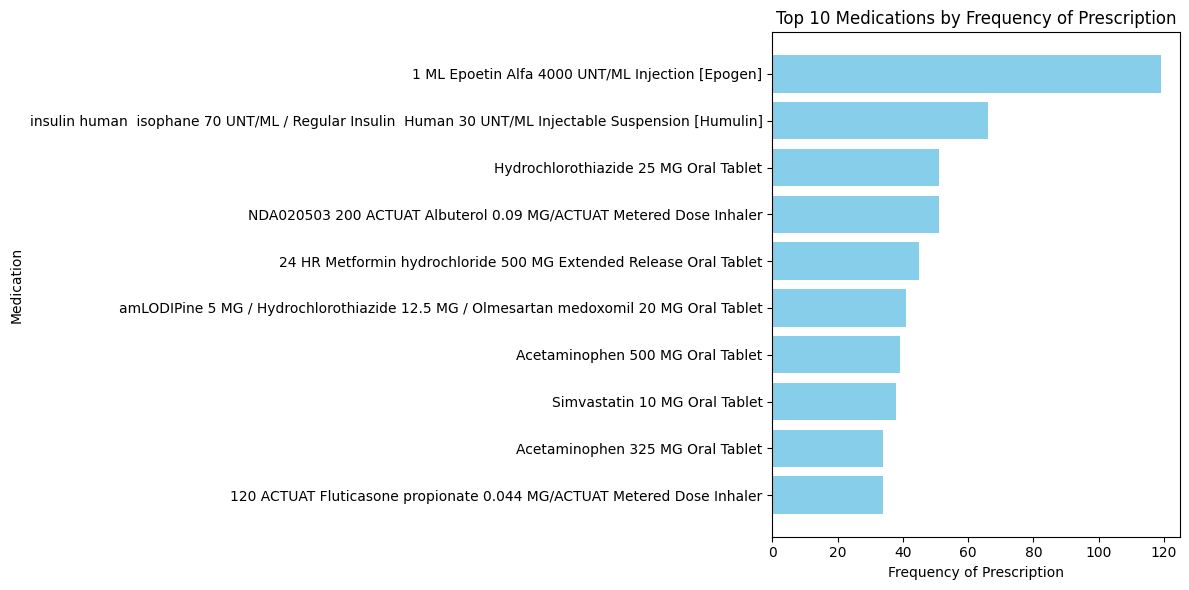

DataFrame[description: string, count: bigint]

In [101]:
# Visualization 3: Rank medications by frequency of prescription
def medication_by_frequency(dataframe, show=True):

  # Explode the medications list into individual rows
  medications_df = dataframe.select(explode(col("medications")).alias("medication"))

  # Group by medication description and count the frequency
  medication_frequency = medications_df.groupBy("medication.description").count()

  # Sort by frequency in descending order
  medication_frequency_sorted = medication_frequency.orderBy(col("count").desc())

  if show:
    # Convert to Pandas for visualization
    medication_frequency_pd = medication_frequency_sorted.toPandas()

    # Plot the top 10 medications by frequency
    top_medications = medication_frequency_pd.head(10)  # Top 10 medications
    plt.figure(figsize=(12, 6))
    plt.barh(top_medications['description'], top_medications['count'], color='skyblue')

    # Labels and title
    plt.xlabel("Frequency of Prescription")
    plt.ylabel("Medication")
    plt.title("Top 10 Medications by Frequency of Prescription")
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.tight_layout()
    plt.show()

  return medication_frequency_sorted

medication_by_frequency(spark_dataframe)

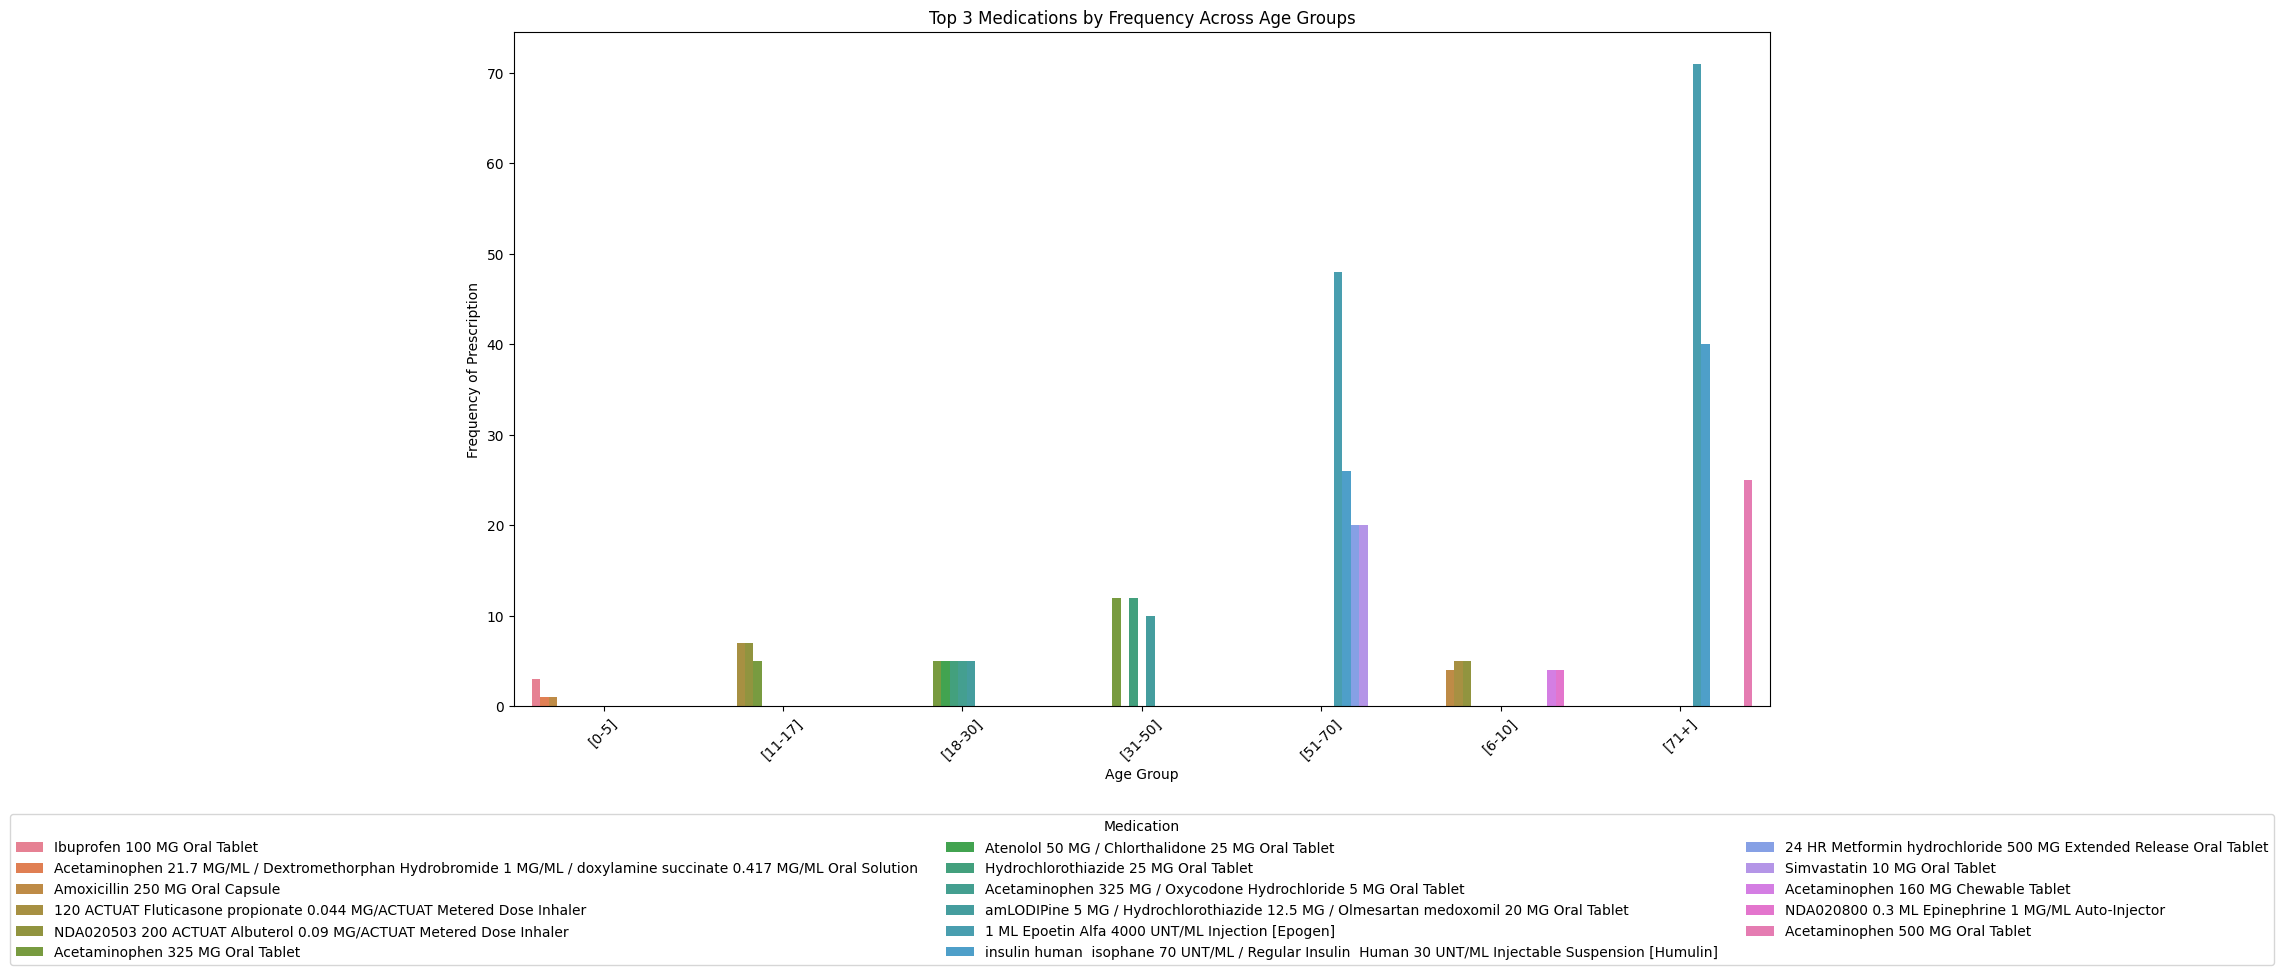

DataFrame[age_group: string, description: string, frequency: bigint, rank: int]

In [103]:
# COVID-19 Case Demographics: Case Breakdown by Age Ranges
# Visualization 4: Analyze medication patterns across different demographic groups (e.g., top 3 per age group)
def medication_by_age(dataframe, show=True):
  # Explode medications and group by age group and medication description
  medication_by_age = dataframe.select(
      col("age_group"), explode(col("medications")).alias("medication")
  )
  # Count frequencies by age group and medication
  medication_counts = medication_by_age.groupBy("age_group", "medication.description").agg(
      count("*").alias("frequency")
  )
  # Create a window specification to rank medications within each age group
  window_spec = Window.partitionBy("age_group").orderBy(col("frequency").desc())
  # Add rank column and filter the top 3 medications per age group
  top_medications_by_age = medication_counts.withColumn(
      "rank", rank().over(window_spec)
  ).filter(col("rank") <= 3)
  if show:
    # Convert to Pandas for visualization
    top_medications_by_age_pd = top_medications_by_age.toPandas()
    # Prepare data for visualization
    top_medications_by_age_pd = top_medications_by_age_pd.sort_values(["age_group", "rank"])
    # Plot a grouped bar chart
    plt.figure(figsize=(20, 10))
    sns.barplot(
        data=top_medications_by_age_pd,
        x="age_group",
        y="frequency",
        hue="description",
        dodge=True
    )
    # Labels and title
    plt.xlabel("Age Group")
    plt.ylabel("Frequency of Prescription")
    plt.title("Top 3 Medications by Frequency Across Age Groups")
    plt.xticks(rotation=45)
    # Move the legend below the graph
    plt.legend(
        title="Medication",
        bbox_to_anchor=(0.5, -0.15),  # Position legend below the graph
        loc="upper center",
        ncol=3  # Arrange legend in 3 columns
    )
    plt.tight_layout()
    plt.show()

  return top_medications_by_age

medication_by_age(spark_dataframe)

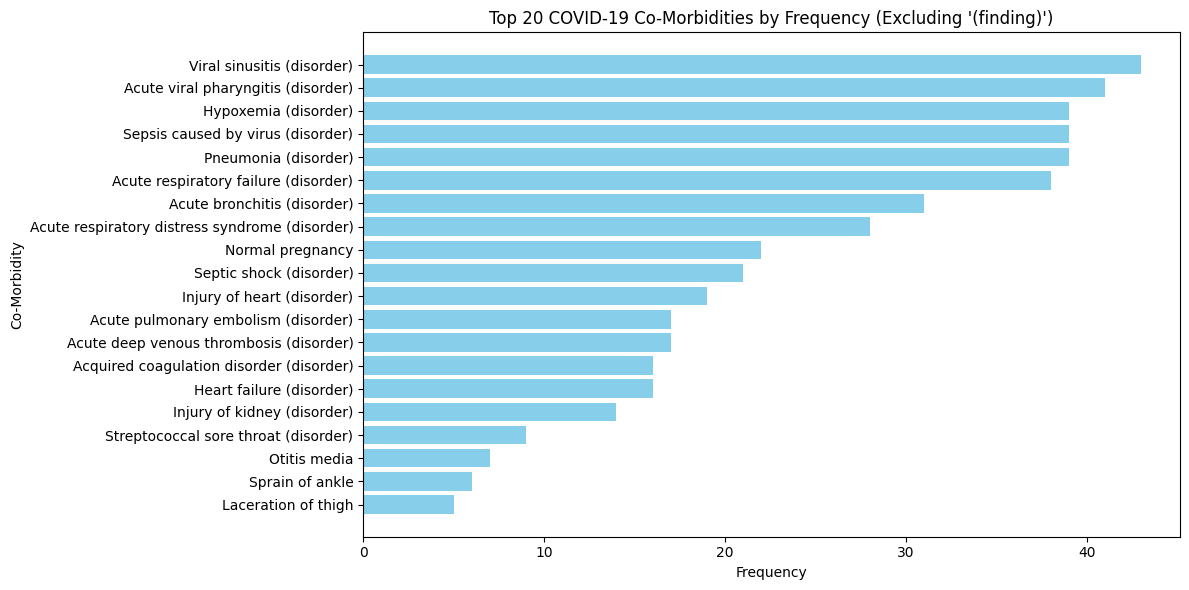

DataFrame[description: string, count: bigint]

In [105]:
# COVID-19 Case Demographics: Case Breakdown by Age Ranges
# Visualization 5: Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset.
def co_morbidity_by_age(dataframe, show=True):
    # Explode the conditions list into individual rows
    conditions_df = dataframe.select(explode(col("conditions")).alias("condition"))

    # Filter out conditions containing "(finding)" or "COVID-19"
    filtered_conditions = conditions_df.filter(
        ~col("condition.description").rlike(r"(?i)\(finding\)") &  # Case-insensitive filter for "(finding)"
        #~col("condition.description").rlike(r"(?i)\(disorder\)") &  # Case-insensitive filter for "(disorder)"
        ~col("condition.description").rlike(r"(?i)COVID-19")      # Case-insensitive filter for "COVID-19"
    )

    # Group by condition description and count the frequency
    comorbidity_counts = filtered_conditions.groupBy("condition.description").count().orderBy(col("count").desc())

    if show:
        # Convert to Pandas for visualization
        comorbidity_counts_pd = comorbidity_counts.toPandas()

        top = 20
        # Slice the top 20
        topCounts = comorbidity_counts_pd.iloc[:top]

        # Plot the upper half of the co-morbidities by frequency
        plt.figure(figsize=(12, 6))
        plt.barh(topCounts['description'], topCounts['count'], color='skyblue')

        # Add labels and title
        plt.xlabel("Frequency")
        plt.ylabel("Co-Morbidity")
        plt.title("Top 20 COVID-19 Co-Morbidities by Frequency (Excluding '(finding)')")
        plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
        plt.tight_layout()

        # Show the plot
        plt.show()

    # Return the filtered comorbidity counts Spark DataFrame
    return comorbidity_counts

co_morbidity_by_age(spark_dataframe)

  ### Analysis 1: Seasonal Trends in COVID-19 Cases
  
  - Question: Do COVID-19 case counts exhibit seasonal trends?

  - Hypothesis: COVID-19 case counts fluctuate by season, with higher cases in colder months.

  - Justification: Understanding seasonal trends can help public health officials prepare resources.

- Methodology:
 1. Extract the encounter.date field and group by month or quarter.
 2. Count the number of cases per month/quarter.
 3. Visualize the case counts using a line or bar chart.

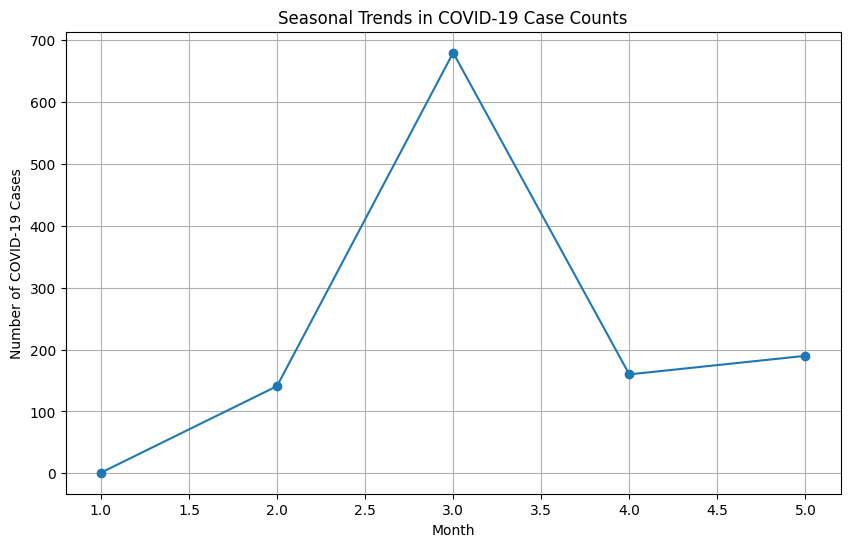

DataFrame[month: int, count: bigint]

In [108]:
# COVID-19 Case Demographics: Case Breakdown by Age Ranges
# Analysis 1: Seasonal Trends in COVID-19 Cases
def seasonal_trends(dataframe, show=True):
  # Extract month and count COVID-19 cases
    seasonal_cases = dataframe \
    .groupBy(month(col("encounter.date")).alias("month")) \
    .count() \
    .orderBy("month")
    if show:
      seasonal_cases_pd = seasonal_cases.toPandas()
      plt.figure(figsize=(10, 6))
      plt.plot(seasonal_cases_pd['month'], seasonal_cases_pd['count'], marker='o')
      plt.xlabel("Month")
      plt.ylabel("Number of COVID-19 Cases")
      plt.title("Seasonal Trends in COVID-19 Case Counts")
      plt.grid()
      plt.show()
    return seasonal_cases

seasonal_trends(spark_dataframe)

  ### Analysis 2: Severity of Symptoms by Gender
  
  - Question: What is the average number of conditions containing (finding) in their description per gender for COVID-19 patients?

  - Hypothesis: Female patients are likely to have a higher average number of (finding)-marked conditions documented compared to male patients due to differences in symptom reporting or diagnostic practices.

  - Justification: This analysis provides insight into potential gender-based differences in medical documentation, which may highlight disparities in diagnostic attention or symptom reporting.

- Methodology:

  1. Explode the conditions Array: Break down the conditions array into individual rows for analysis.
  
  2. Filter for (finding) Conditions: Include only rows where the description contains (finding).

  3. Group by Gender:
    - Calculate the total number of (finding) conditions for each gender.
    - Count the number of patients for each gender.

  4. Calculate Averages: Divide the total (finding) conditions by the number of patients for each gender.

  5. Visualize: Create a bar chart showing the average number of (finding) conditions per gender.

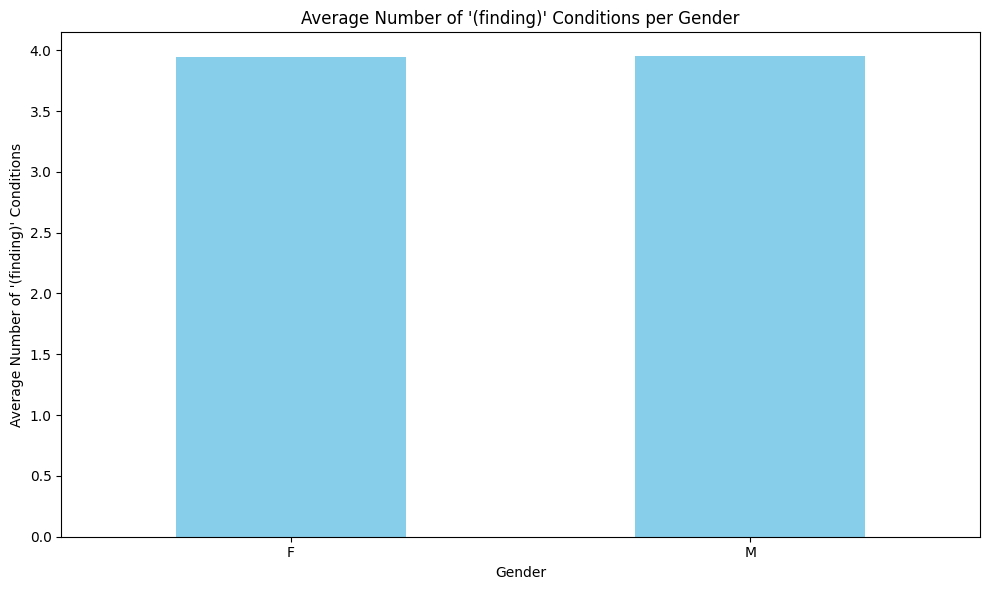

DataFrame[gender: string, average_findings: double]

In [122]:
# COVID-19 Case Demographics: Case Breakdown by Age Ranges
# Analysis 2: Severity of Symptoms by Gender
from pyspark.sql.functions import col, explode, count, avg

def average_findings_by_gender(dataframe, show=True):
    # Explode the conditions array into individual rows
    exploded_conditions = dataframe.select(
        explode(col("conditions")).alias("condition"),
        col("demographics.gender").alias("gender"),
        col("demographics.name").alias("patient_id")  # Use name as a unique identifier for each patient
    )

    # Filter for conditions containing "(finding)" in the description
    findings = exploded_conditions.filter(
        col("condition.description").rlike(r"(?i)\(finding\)")
    )

    # Total number of findings per gender
    findings_count_by_gender = findings.groupBy("gender").agg(
        count("condition.description").alias("total_findings")
    )

    # Number of patients per gender
    patients_per_gender = dataframe.groupBy(col("demographics.gender").alias("gender")).agg(
        count("demographics.name").alias("total_patients")
    )

    # Calculate average findings per gender
    average_findings = findings_count_by_gender.join(
        patients_per_gender, findings_count_by_gender.gender == patients_per_gender.gender
    ).select(
        findings_count_by_gender.gender,
        (col("total_findings") / col("total_patients")).alias("average_findings")
    )

    if show:
        # Convert to Pandas for visualization
        average_findings_pd = average_findings.toPandas()

        # Plot the average findings by gender
        average_findings_pd.plot(kind="bar", x="gender", y="average_findings", legend=False, figsize=(10, 6), color="skyblue")
        plt.xlabel("Gender")
        plt.ylabel("Average Number of '(finding)' Conditions")
        plt.title("Average Number of '(finding)' Conditions per Gender")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    return average_findings

# Call the function with your DataFrame
average_findings_by_gender(spark_dataframe)

  ### Analysis 3: How Does a Positive COVID-19 Test Affect Oxygen Saturation?
  
  - Question: Does a positive COVID-19 test correlate with lower oxygen saturation levels compared to patients with negative or unknown COVID-19 test results?

  - Hypothesis: Patients with a positive COVID-19 test will exhibit significantly lower average oxygen saturation levels compared to those with negative or unknown test results.

  - Justification:Oxygen saturation is a critical measure of respiratory function, and reduced levels can indicate severe respiratory impact, a hallmark of COVID-19's effect on the body. By comparing oxygen saturation between positive and negative cases, this analysis provides valuable insights into how COVID-19 may compromise lung function. These findings can help clinicians identify high-risk patients for early intervention.
  
- Methodology:
  1. Filter the Data: Select patients with recorded oxygen saturation levels from the vitals.oxygen_saturation field.

  2. Filter for COVID-19 test results (laboratory.covid19.result) and classify patients as Positive or Negative/Unknown.

  3. Group Patients: Group patients by COVID-19 status (Positive vs. Negative/Unknown).

  4. Compute Statistics: Calculate summary statistics for oxygen saturation levels, including mean, median, standard deviation, and range for each group.

  5. Visualize the Results: Create a boxplot to compare the distribution of oxygen saturation levels between the two groups. Optionally, overlay histograms to visualize the frequency distribution of oxygen saturation levels.

<ipython-input-138-68ab6adb7704>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=oxygen_data_pd, x="covid_status", y="oxygen_saturation", palette="viridis")


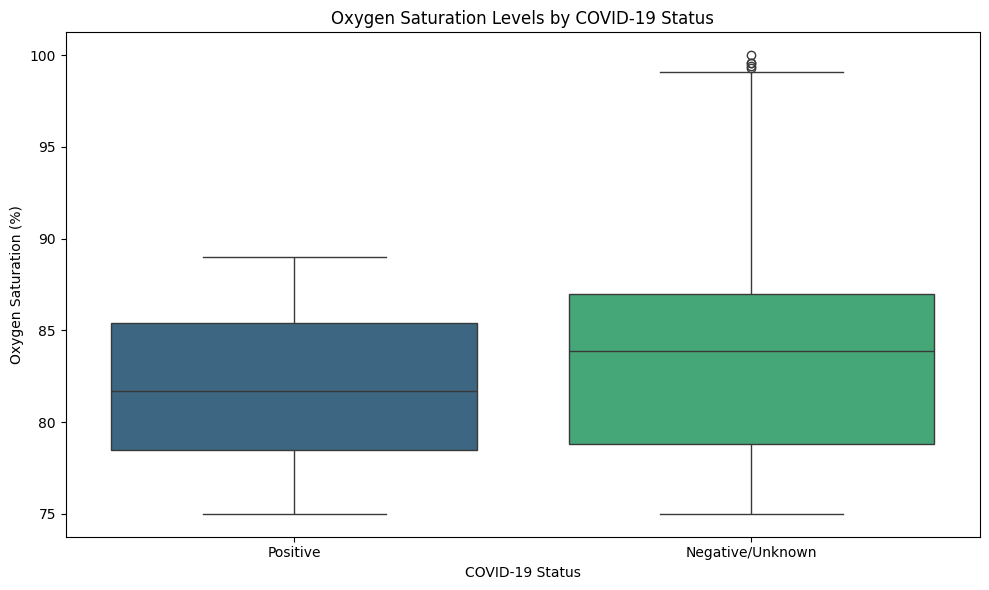

+----------------+----------------------+------------------------+-----------+
|covid_status    |mean_oxygen_saturation|stddev_oxygen_saturation|num_records|
+----------------+----------------------+------------------------+-----------+
|Negative/Unknown|83.76751592356686     |5.8256973591316         |314        |
|Positive        |81.90435153583616     |4.014870714601872       |1172       |
+----------------+----------------------+------------------------+-----------+



DataFrame[covid_status: string, mean_oxygen_saturation: double, stddev_oxygen_saturation: double, num_records: bigint]

In [138]:
# COVID-19 Case Demographics: Case Breakdown by Age Ranges
# Analysis 3: How Does a Positive COVID-19 Test Affect Oxygen Saturation?
def analyze_oxygen_saturation(dataframe, show=True):
    # Extract the value field from the nested oxygen_saturation structure
    oxygen_data = dataframe.select(
        col("demographics.name").alias("patient_id"),
        col("laboratory.covid19.result").alias("covid_result"),
        col("vitals.current.oxygen_saturation.value").alias("oxygen_saturation")  # Extract the value field
    ).filter(
        col("oxygen_saturation").isNotNull()  # Filter out rows with NULL oxygen saturation
    )

    # Add a column for COVID-19 test status
    oxygen_data = oxygen_data.withColumn(
        "covid_status",
        when(col("covid_result") == "Detected (qualifier value)", "Positive")
        .otherwise("Negative/Unknown")
    )

    # Calculate summary statistics
    summary_stats = oxygen_data.groupBy("covid_status").agg(
        mean("oxygen_saturation").alias("mean_oxygen_saturation"),
        stddev("oxygen_saturation").alias("stddev_oxygen_saturation"),
        count("oxygen_saturation").alias("num_records")
    )

    if show:
        # Convert to Pandas for visualization
        oxygen_data_pd = oxygen_data.toPandas()

        # Create a boxplot to compare oxygen saturation levels
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=oxygen_data_pd, x="covid_status", y="oxygen_saturation", palette="viridis")
        plt.xlabel("COVID-19 Status")
        plt.ylabel("Oxygen Saturation (%)")
        plt.title("Oxygen Saturation Levels by COVID-19 Status")
        plt.tight_layout()
        plt.show()

    # Show the summary statistics
    summary_stats.show(truncate=False)
    return summary_stats

# Call the function with your DataFrame
analyze_oxygen_saturation(age_groups_dataframe)

In [140]:
# For Debugging
'''
# File Paths
data_path = '/content/drive/MyDrive/ICS438/Assignment3/parsed_notes.jsonl.gz'
schema_path = '/content/drive/MyDrive/ICS438/Assignment3/schema.py'

# MAIN FUNCTION
def main_part2():
  # Start tracking time
  start_time = time.time()
  # Set up Spark DataFrames
  spark = SparkSession.builder.appName("spark_analysis").getOrCreate()
  # Load Patient Records into DataFrame (Apache Spark can automatically read from .jsonl.gz)
  df = spark.read.json(data_path)

  # Add the 'age_group' column to the DataFrame
  df_age_groups = df.withColumn(
      "age_group",
      when(col("demographics.age") <= 5, "[0-5]")
      .when((col("demographics.age") >= 6) & (col("demographics.age") <= 10), "[6-10]")
      .when((col("demographics.age") >= 11) & (col("demographics.age") <= 17), "[11-17]")
      .when((col("demographics.age") >= 18) & (col("demographics.age") <= 30), "[18-30]")
      .when((col("demographics.age") >= 31) & (col("demographics.age") <= 50), "[31-50]")
      .when((col("demographics.age") >= 51) & (col("demographics.age") <= 70), "[51-70]")
      .otherwise("[71+]")
  )

  # Filter for positive COVID-19 results and group by age group and count
  df_covid_positive = df_age_groups.filter(
      col("laboratory.covid19.result")  == "Detected (qualifier value)"
      )

  age_groups_dataframe.select("vitals").printSchema()

  # Display the first 10 rows of the DataFrame
  #df_age_groups.show(10, truncate=False)

  # Track and print time taken
  track_time(start_time)

# Run the main function
if __name__ == '__main__':
    main_part2()
'''

'\n# File Paths\ndata_path = \'/content/drive/MyDrive/ICS438/Assignment3/parsed_notes.jsonl.gz\'\nschema_path = \'/content/drive/MyDrive/ICS438/Assignment3/schema.py\'\n\n# MAIN FUNCTION\ndef main_part2():\n  # Start tracking time\n  start_time = time.time()\n  # Set up Spark DataFrames\n  spark = SparkSession.builder.appName("spark_analysis").getOrCreate()\n  # Load Patient Records into DataFrame (Apache Spark can automatically read from .jsonl.gz)\n  df = spark.read.json(data_path)\n\n  # Add the \'age_group\' column to the DataFrame\n  df_age_groups = df.withColumn(\n      "age_group",\n      when(col("demographics.age") <= 5, "[0-5]")\n      .when((col("demographics.age") >= 6) & (col("demographics.age") <= 10), "[6-10]")\n      .when((col("demographics.age") >= 11) & (col("demographics.age") <= 17), "[11-17]")\n      .when((col("demographics.age") >= 18) & (col("demographics.age") <= 30), "[18-30]")\n      .when((col("demographics.age") >= 31) & (col("demographics.age") <= 50), "[